<a href="https://colab.research.google.com/github/hungjoe/HW9_LLM-/blob/main/HW9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import json
import nbformat

# 讀取目前正在編輯的 notebook
notebook_path = '/content/drive/MyDrive/深度生成模型/作業五/HW9'
print("Fixing:", notebook_path)

nb = nbformat.read(notebook_path, as_version=nbformat.NO_CONVERT)

# 移除 metadata.widgets
if "widgets" in nb.get("metadata", {}):
    print("Removing metadata.widgets ...")
    nb["metadata"].pop("widgets")

# 清掉每個 cell 可能留存的 widget state
for cell in nb["cells"]:
    md = cell.get("metadata", {})
    for bad_key in ["widgets", "widget_state", "state"]:
        if bad_key in md:
            print(f"Removing cell metadata: {bad_key}")
            md.pop(bad_key)

# 重新存檔
fixed_path = notebook_path.replace(".ipynb", "_fixed.ipynb")
nbformat.write(nb, fixed_path)

print("Done! Fixed notebook saved as:", fixed_path)


Fixing: /content/drive/MyDrive/深度生成模型/作業五/HW9
Removing metadata.widgets ...
Done! Fixed notebook saved as: /content/drive/MyDrive/深度生成模型/作業五/HW9


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 環境設定&資料載入

三種方法：
Zero-shot：在沒有接受任何特定任務訓練的情況下，僅透過自然語言指令來執行任務。
Few-shot：在prompt中提供少量標註範例,引導模型理解任務。
LoRA 微調：LoRA 是一種參數高效的微調技術,透過在模型中插入低秩矩陣來學習任務特定的知識,只需訓練少量參數即可達到良好效果。

In [ ]:
# 1. 安裝必要套件
print("📦 安裝套件...")
!pip install -q datasets transformers accelerate peft bitsandbytes
!pip install -q torch torchvision torchaudio
!pip install -q scikit-learn matplotlib seaborn pandas numpy
!pip install -q trl
print("✅ 套件安裝完成!")

📦 安裝套件...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 kB 14.0 MB/s eta 0:00:00
✅ 套件安裝完成!


In [ ]:
# 2. 匯入套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

from datasets import load_dataset, Dataset
import torch

# 設定繪圖風格
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')

# 設定隨機種子
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

print("✅ 套件匯入完成!")
print(f"🔧 PyTorch 版本: {torch.__version__}")
print(f"🎮 CUDA 可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")

✅ 套件匯入完成!
🔧 PyTorch 版本: 2.8.0+cu126
🎮 CUDA 可用: True
🎮 GPU: Tesla T4


In [ ]:
# 3. 載入 Emotion Dataset
print("📥 正在載入 Emotion Dataset...")
dataset = load_dataset("dair-ai/emotion")

print("\n✅ 資料載入完成!")
print(f"\n📊 資料集結構:")
print(dataset)

print("\n📝 訓練集範例 (前 3 筆):")
for i in range(3):
    print(f"\n範例 {i+1}:")
    print(f"  文本: {dataset['train'][i]['text']}")
    print(f"  標籤: {dataset['train'][i]['label']}")

📥 正在載入 Emotion Dataset...


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]


✅ 資料載入完成!

📊 資料集結構:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

📝 訓練集範例 (前 3 筆):

範例 1:
  文本: i didnt feel humiliated
  標籤: 0

範例 2:
  文本: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
  標籤: 0

範例 3:
  文本: im grabbing a minute to post i feel greedy wrong
  標籤: 3


In [ ]:
# 4. 定義情緒與風險映射
emotion_labels = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

emotion_to_id = {v: k for k, v in emotion_labels.items()}

emotion_to_risk = {
    'sadness': 2,    # 高風險
    'joy': 0,        # 低風險
    'love': 0,       # 低風險
    'anger': 1,      # 中風險
    'fear': 1,       # 中風險
    'surprise': 0    # 低風險
}

risk_labels = {
    0: 'low_risk',
    1: 'mid_risk',
    2: 'high_risk'
}

def emotion_id_to_risk_id(emotion_id):
    """將情緒標籤 ID 轉換為風險等級 ID"""
    emotion_name = emotion_labels[emotion_id]
    return emotion_to_risk[emotion_name]

print("🔄 情緒 → 風險映射:")
print("="*50)
for emotion_id, emotion_name in emotion_labels.items():
    risk_id = emotion_id_to_risk_id(emotion_id)
    risk_name = risk_labels[risk_id]
    print(f"  {emotion_name:10s} → {risk_name:10s}")

print("\n✅ 映射函數定義完成!")

🔄 情緒 → 風險映射:
  sadness    → high_risk 
  joy        → low_risk  
  love       → low_risk  
  anger      → mid_risk  
  fear       → mid_risk  
  surprise   → low_risk  

✅ 映射函數定義完成!


In [ ]:
# 5. 資料探索與分析
def analyze_dataset_split(dataset_split, split_name):
    """分析資料集"""
    df = pd.DataFrame(dataset_split)
    df['emotion_name'] = df['label'].map(emotion_labels)
    df['risk_id'] = df['label'].apply(emotion_id_to_risk_id)
    df['risk_name'] = df['risk_id'].map(risk_labels)

    print(f"\n{'='*60}")
    print(f"📊 {split_name} 資料集分析")
    print(f"{'='*60}")
    print(f"\n總樣本數: {len(df)}")

    print(f"\n🎭 情緒分布:")
    emotion_counts = df['emotion_name'].value_counts()
    for emotion, count in emotion_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {emotion:10s}: {count:5d} ({percentage:5.2f}%)")

    print(f"\n⚠️ 風險等級分布:")
    risk_counts = df['risk_name'].value_counts()
    for risk, count in risk_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {risk:10s}: {count:5d} ({percentage:5.2f}%)")

    df['text_length'] = df['text'].str.len()
    print(f"\n📏 文本長度統計:")
    print(f"  平均: {df['text_length'].mean():.2f} 字元")
    print(f"  最短: {df['text_length'].min()} 字元")
    print(f"  最長: {df['text_length'].max()} 字元")
    print(f"  中位數: {df['text_length'].median():.2f} 字元")

    return df

train_df = analyze_dataset_split(dataset['train'], 'Training')
val_df = analyze_dataset_split(dataset['validation'], 'Validation')
test_df = analyze_dataset_split(dataset['test'], 'Test')


📊 Training 資料集分析

總樣本數: 16000

🎭 情緒分布:
  joy       :  5362 (33.51%)
  sadness   :  4666 (29.16%)
  anger     :  2159 (13.49%)
  fear      :  1937 (12.11%)
  love      :  1304 ( 8.15%)
  surprise  :   572 ( 3.57%)

⚠️ 風險等級分布:
  low_risk  :  7238 (45.24%)
  high_risk :  4666 (29.16%)
  mid_risk  :  4096 (25.60%)

📏 文本長度統計:
  平均: 96.85 字元
  最短: 7 字元
  最長: 300 字元
  中位數: 86.00 字元

📊 Validation 資料集分析

總樣本數: 2000

🎭 情緒分布:
  joy       :   704 (35.20%)
  sadness   :   550 (27.50%)
  anger     :   275 (13.75%)
  fear      :   212 (10.60%)
  love      :   178 ( 8.90%)
  surprise  :    81 ( 4.05%)

⚠️ 風險等級分布:
  low_risk  :   963 (48.15%)
  high_risk :   550 (27.50%)
  mid_risk  :   487 (24.35%)

📏 文本長度統計:
  平均: 95.35 字元
  最短: 11 字元
  最長: 295 字元
  中位數: 85.00 字元

📊 Test 資料集分析

總樣本數: 2000

🎭 情緒分布:
  joy       :   695 (34.75%)
  sadness   :   581 (29.05%)
  anger     :   275 (13.75%)
  fear      :   224 (11.20%)
  love      :   159 ( 7.95%)
  surprise  :    66 ( 3.30%)

⚠️ 風險等級分布:
  low_risk  :   920

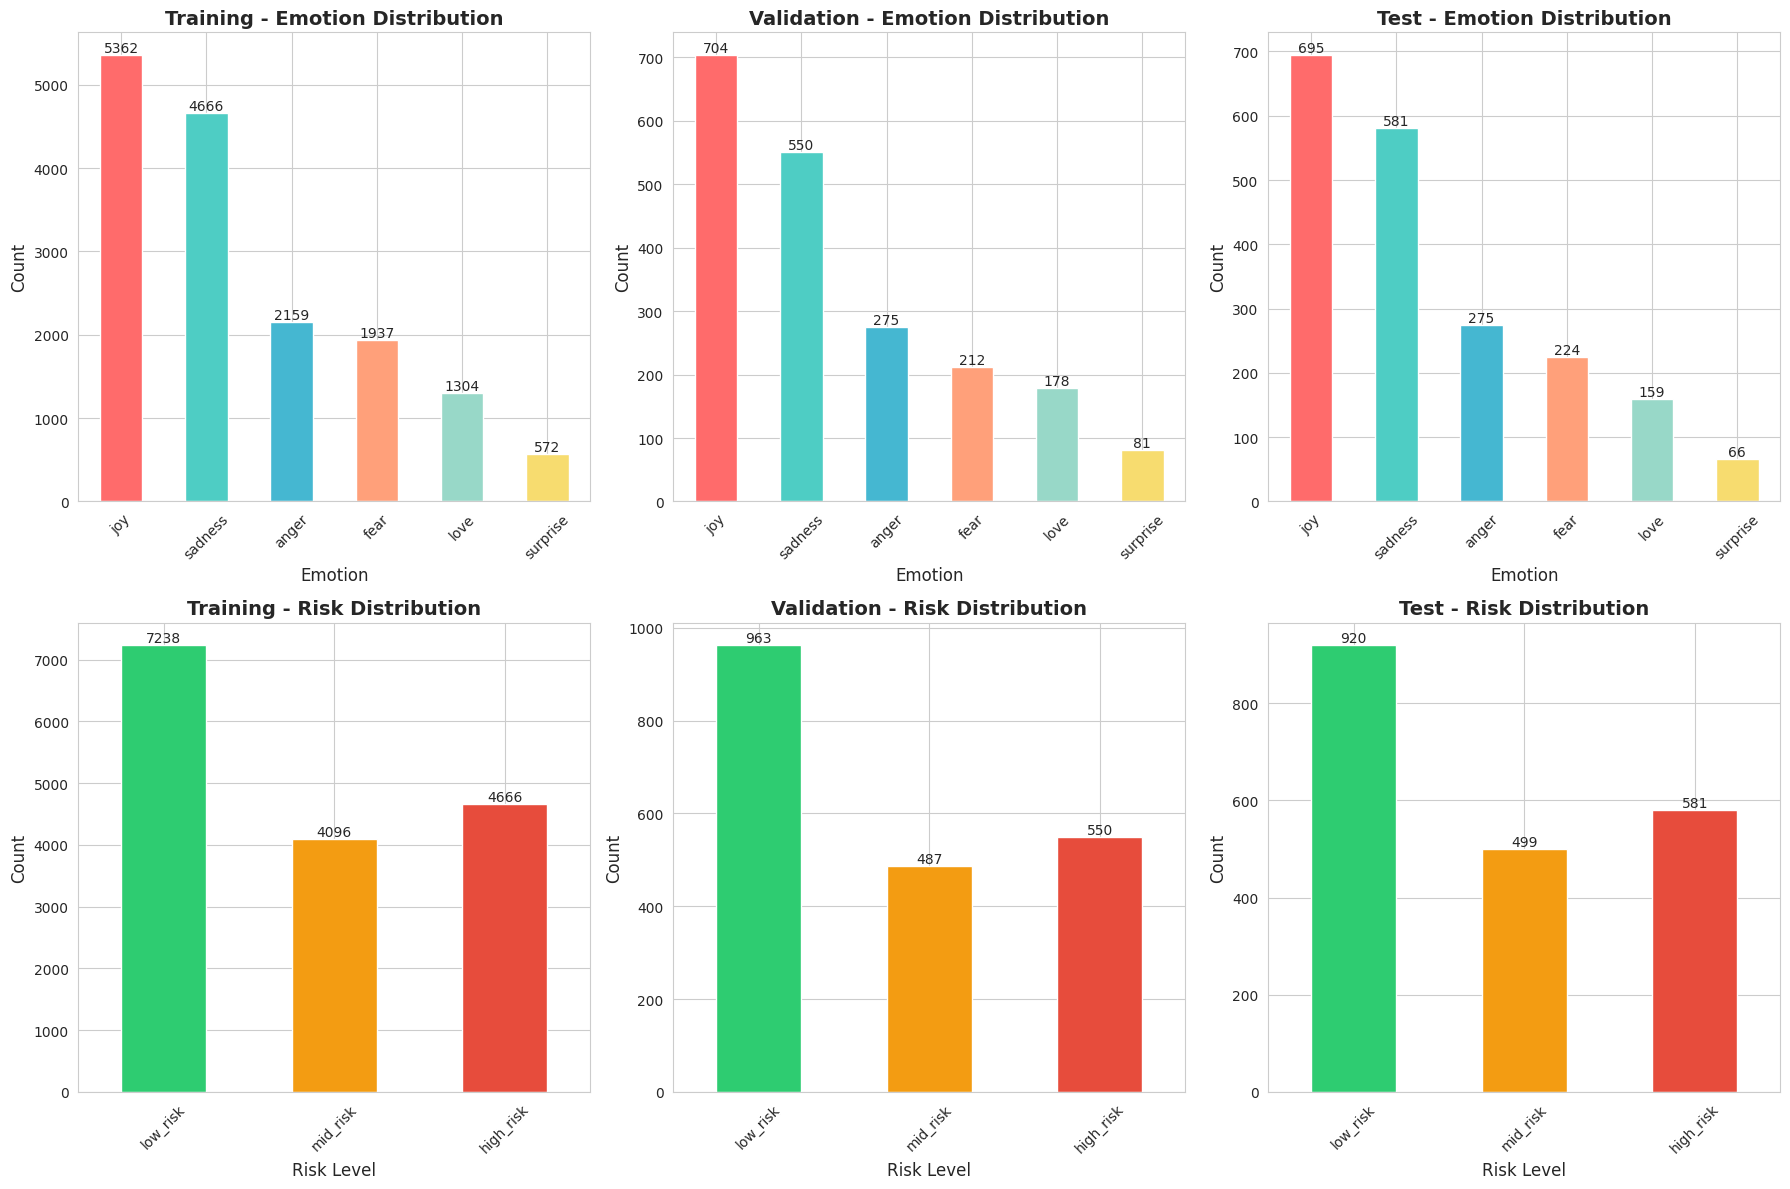


✅ 圖表生成完成!


In [ ]:
# 6. 資料視覺化
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

emotion_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
risk_colors = ['#2ECC71', '#F39C12', '#E74C3C']

datasets_dict = {
    'Training': train_df,
    'Validation': val_df,
    'Test': test_df
}

for idx, (split_name, df) in enumerate(datasets_dict.items()):
    # 情緒分布
    ax1 = axes[0, idx]
    emotion_counts = df['emotion_name'].value_counts()
    emotion_counts.plot(kind='bar', ax=ax1, color=emotion_colors)
    ax1.set_title(f'{split_name} - Emotion Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Emotion', fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    for container in ax1.containers:
        ax1.bar_label(container, fontsize=10)

    # 風險分布
    ax2 = axes[1, idx]
    risk_counts = df['risk_name'].value_counts().reindex(['low_risk', 'mid_risk', 'high_risk'], fill_value=0)
    risk_counts.plot(kind='bar', ax=ax2, color=risk_colors)
    ax2.set_title(f'{split_name} - Risk Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Risk Level', fontsize=12)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    for container in ax2.containers:
        ax2.bar_label(container, fontsize=10)

plt.tight_layout()
plt.show()
print("\n✅ 圖表生成完成!")

In [ ]:
# 7. 儲存處理後的資料
print("💾 正在儲存資料...")

train_df.to_csv('train_with_risk.csv', index=False)
val_df.to_csv('val_with_risk.csv', index=False)
test_df.to_csv('test_with_risk.csv', index=False)

print("\n✅ 資料已儲存!")
print("  - train_with_risk.csv")
print("  - val_with_risk.csv")
print("  - test_with_risk.csv")

print("\n📊 最終統計:")
print(f"  訓練集: {len(train_df):,} 筆")
print(f"  驗證集: {len(val_df):,} 筆")
print(f"  測試集: {len(test_df):,} 筆")
print(f"  總計:   {len(train_df) + len(val_df) + len(test_df):,} 筆")

💾 正在儲存資料...

✅ 資料已儲存!
  - train_with_risk.csv
  - val_with_risk.csv
  - test_with_risk.csv

📊 最終統計:
  訓練集: 16,000 筆
  驗證集: 2,000 筆
  測試集: 2,000 筆
  總計:   20,000 筆


# zero shot

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("📥 載入處理後的資料...")
test_df = pd.read_csv('test_with_risk.csv')

# 標籤映射
emotion_labels = {
    0: 'sadness', 1: 'joy', 2: 'love',
    3: 'anger', 4: 'fear', 5: 'surprise'
}

risk_labels = {
    0: 'low_risk', 1: 'mid_risk', 2: 'high_risk'
}

emotion_to_risk = {
    'sadness': 2, 'joy': 0, 'love': 0,
    'anger': 1, 'fear': 1, 'surprise': 0
}

print(f"✅ 測試集載入完成: {len(test_df)} 筆")
print(f"🎮 CUDA 可用: {torch.cuda.is_available()}")

📥 載入處理後的資料...
✅ 測試集載入完成: 2000 筆
🎮 CUDA 可用: True


In [ ]:
# 2. 載入 Zero-shot 模型
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

print(f"📦 載入模型: {model_name}")
print("⏳ 請稍候...")

# 4-bit 量化配置
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# 載入 tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# 載入模型
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

model.eval()

print("\n✅ 模型載入完成!")
print(f"📊 參數量: {model.num_parameters() / 1e9:.2f}B")
print(f"💾 記憶體: {model.get_memory_footprint() / 1e9:.2f} GB")

📦 載入模型: TinyLlama/TinyLlama-1.1B-Chat-v1.0
⏳ 請稍候...

✅ 模型載入完成!
📊 參數量: 1.10B
💾 記憶體: 0.75 GB


In [ ]:
# 3. 設計 Zero-shot Prompt
def create_zero_shot_prompt(text):
    """建立 Zero-shot prompt"""
    prompt = f"""<|system|>
You are an emotion classification expert. Your task is to classify the emotion expressed in the given text.

Choose ONE emotion from: sadness, joy, love, anger, fear, surprise

Return ONLY the emotion label, nothing else.
</|system|>
<|user|>
Text: "{text}"

Emotion:</|user|>
<|assistant|>
"""
    return prompt

# 測試 prompt
sample_text = test_df.iloc[0]['text']
sample_prompt = create_zero_shot_prompt(sample_text)

print("📝 Zero-shot Prompt 範例:")
print("="*80)
print(sample_prompt)
print("="*80)

📝 Zero-shot Prompt 範例:
<|system|>
You are an emotion classification expert. Your task is to classify the emotion expressed in the given text.

Choose ONE emotion from: sadness, joy, love, anger, fear, surprise

Return ONLY the emotion label, nothing else.
</|system|>
<|user|>
Text: "im feeling rather rotten so im not very ambitious right now"

Emotion:</|user|>
<|assistant|>



In [ ]:
# 4. 推論函數
def predict_emotion_zero_shot(text, model, tokenizer, max_new_tokens=10):
    """使用 Zero-shot 預測情緒"""
    prompt = create_zero_shot_prompt(text)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.1,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    try:
        response = generated_text.split("<|assistant|>")[-1].strip().lower()
        response = response.replace('.', '').replace(',', '').replace('!', '').strip()

        valid_emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

        for emotion in valid_emotions:
            if emotion in response:
                return emotion

        return 'joy'  # 預設值
    except:
        return 'joy'

# 測試推論
print("🧪 測試 Zero-shot 推論...")
print("="*80)

for i in range(3):
    text = test_df.iloc[i]['text']
    true_emotion = emotion_labels[test_df.iloc[i]['label']]
    pred_emotion = predict_emotion_zero_shot(text, model, tokenizer)

    print(f"\n範例 {i+1}:")
    print(f"  文本: {text}")
    print(f"  真實: {true_emotion}")
    print(f"  預測: {pred_emotion}")
    print(f"  {'✅ 正確' if pred_emotion == true_emotion else '❌ 錯誤'}")

print("\n" + "="*80)

🧪 測試 Zero-shot 推論...

範例 1:
  文本: im feeling rather rotten so im not very ambitious right now
  真實: sadness
  預測: joy
  ❌ 錯誤

範例 2:
  文本: im updating my blog because i feel shitty
  真實: sadness
  預測: joy
  ❌ 錯誤

範例 3:
  文本: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
  真實: sadness
  預測: sadness
  ✅ 正確



In [ ]:
# 5. 對測試集進行完整推論
sample_size = 500  # 使用 500 筆測試
test_sample = test_df.sample(n=min(sample_size, len(test_df)), random_state=42)

print(f"🚀 開始 Zero-shot 推論 ({len(test_sample)} 筆)...")
print("⏳ 預計需要數分鐘...\n")

predictions = []
true_labels = []

for idx, row in tqdm(test_sample.iterrows(), total=len(test_sample), desc="Zero-shot"):
    text = row['text']
    true_emotion_id = row['label']

    pred_emotion = predict_emotion_zero_shot(text, model, tokenizer)

    emotion_to_id = {v: k for k, v in emotion_labels.items()}
    pred_emotion_id = emotion_to_id.get(pred_emotion, 1)

    predictions.append(pred_emotion_id)
    true_labels.append(true_emotion_id)

test_sample = test_sample.copy()
test_sample['pred_emotion_id'] = predictions
test_sample['pred_emotion'] = test_sample['pred_emotion_id'].map(emotion_labels)

print("\n✅ Zero-shot 推論完成!")

🚀 開始 Zero-shot 推論 (500 筆)...
⏳ 預計需要數分鐘...



Zero-shot: 100%|██████████| 500/500 [04:43<00:00,  1.76it/s]


✅ Zero-shot 推論完成!


In [ ]:
# 6. 計算風險等級
test_sample['pred_risk_id'] = test_sample['pred_emotion'].map(emotion_to_risk)
test_sample['pred_risk'] = test_sample['pred_risk_id'].map(risk_labels)

print("📊 情緒 → 風險映射完成")
print("\n範例結果:")
for idx, row in test_sample.head(3).iterrows():
    print(f"\n文本: {row['text'][:50]}...")
    print(f"  情緒: {row['emotion_name']} → {row['pred_emotion']}")
    print(f"  風險: {row['risk_name']} → {row['pred_risk']}")

📊 情緒 → 風險映射完成

範例結果:

文本: i feel so dirty but after spending a day at the mk...
  情緒: sadness → joy
  風險: high_risk → low_risk

文本: i could feel his breath on me and smell the sweet ...
  情緒: joy → love
  風險: low_risk → low_risk

文本: i just want to feel loved by you...
  情緒: love → love
  風險: low_risk → low_risk


In [ ]:
# 7. 評估指標計算
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print("📊 情緒分類評估結果 (Zero-shot)")
print("="*80)

y_true_emotion = test_sample['label'].values
y_pred_emotion = test_sample['pred_emotion_id'].values

emotion_accuracy = accuracy_score(y_true_emotion, y_pred_emotion)
emotion_f1_macro = f1_score(y_true_emotion, y_pred_emotion, average='macro')
emotion_f1_weighted = f1_score(y_true_emotion, y_pred_emotion, average='weighted')

print(f"\n✨ 準確率: {emotion_accuracy:.4f} ({emotion_accuracy*100:.2f}%)")
print(f"\n📈 F1 分數:")
print(f"  Macro:    {emotion_f1_macro:.4f}")
print(f"  Weighted: {emotion_f1_weighted:.4f}")

print(f"\n📋 詳細分類報告:")
print(classification_report(
    y_true_emotion, y_pred_emotion,
    target_names=list(emotion_labels.values()),
    digits=4
))

# 風險等級評估
print("\n" + "="*80)
print("⚠️ 風險等級評估結果 (Zero-shot)")
print("="*80)

y_true_risk = test_sample['risk_id'].values
y_pred_risk = test_sample['pred_risk_id'].values

risk_accuracy = accuracy_score(y_true_risk, y_pred_risk)
risk_f1_macro = f1_score(y_true_risk, y_pred_risk, average='macro')
risk_f1_weighted = f1_score(y_true_risk, y_pred_risk, average='weighted')

print(f"\n✨ 準確率: {risk_accuracy:.4f} ({risk_accuracy*100:.2f}%)")
print(f"\n📈 F1 分數:")
print(f"  Macro:    {risk_f1_macro:.4f}")
print(f"  Weighted: {risk_f1_weighted:.4f}")

print(f"\n📋 詳細分類報告:")
print(classification_report(
    y_true_risk, y_pred_risk,
    target_names=list(risk_labels.values()),
    digits=4
))


📊 情緒分類評估結果 (Zero-shot)

✨ 準確率: 0.4540 (45.40%)

📈 F1 分數:
  Macro:    0.3094
  Weighted: 0.4130

📋 詳細分類報告:
              precision    recall  f1-score   support

     sadness     0.5364    0.3986    0.4574       148
         joy     0.4238    0.7943    0.5527       175
        love     0.3077    0.1778    0.2254        45
       anger     0.6087    0.2414    0.3457        58
        fear     0.6000    0.1091    0.1846        55
    surprise     0.3333    0.0526    0.0909        19

    accuracy                         0.4540       500
   macro avg     0.4683    0.2956    0.3094       500
weighted avg     0.4841    0.4540    0.4130       500


⚠️ 風險等級評估結果 (Zero-shot)

✨ 準確率: 0.5580 (55.80%)

📈 F1 分數:
  Macro:    0.4675
  Weighted: 0.5181

📋 詳細分類報告:
              precision    recall  f1-score   support

    low_risk     0.5602    0.8368    0.6711       239
    mid_risk     0.6061    0.1770    0.2740       113
   high_risk     0.5364    0.3986    0.4574       148

    accuracy            

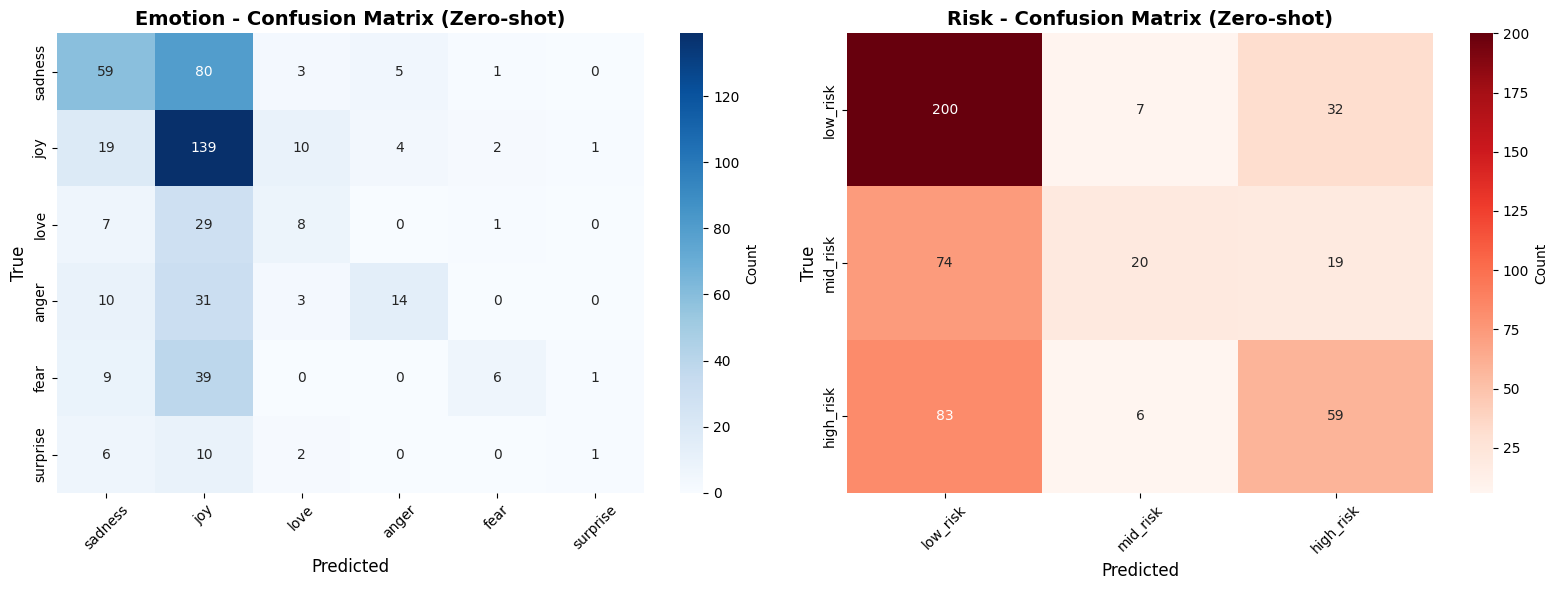


✅ 混淆矩陣已生成


In [ ]:
# 8. 混淆矩陣視覺化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 情緒混淆矩陣
cm_emotion = confusion_matrix(y_true_emotion, y_pred_emotion)
ax1 = axes[0]
sns.heatmap(
    cm_emotion, annot=True, fmt='d', cmap='Blues',
    xticklabels=emotion_labels.values(),
    yticklabels=emotion_labels.values(),
    ax=ax1, cbar_kws={'label': 'Count'}
)
ax1.set_title('Emotion - Confusion Matrix (Zero-shot)',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Predicted', fontsize=12)
ax1.set_ylabel('True', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# 風險混淆矩陣
cm_risk = confusion_matrix(y_true_risk, y_pred_risk)
ax2 = axes[1]
sns.heatmap(
    cm_risk, annot=True, fmt='d', cmap='Reds',
    xticklabels=risk_labels.values(),
    yticklabels=risk_labels.values(),
    ax=ax2, cbar_kws={'label': 'Count'}
)
ax2.set_title('Risk - Confusion Matrix (Zero-shot)',
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Predicted', fontsize=12)
ax2.set_ylabel('True', fontsize=12)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
print("\n✅ 混淆矩陣已生成")

In [ ]:
# 9. 儲存結果
test_sample.to_csv('zero_shot_predictions.csv', index=False)

metrics_dict = {
    'Method': 'Zero-shot',
    'Model': model_name,
    'Sample_Size': len(test_sample),
    'Emotion_Accuracy': emotion_accuracy,
    'Emotion_F1_Macro': emotion_f1_macro,
    'Emotion_F1_Weighted': emotion_f1_weighted,
    'Risk_Accuracy': risk_accuracy,
    'Risk_F1_Macro': risk_f1_macro,
    'Risk_F1_Weighted': risk_f1_weighted
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df.to_csv('zero_shot_metrics.csv', index=False)

print("✅ 結果已儲存:")
print("  - zero_shot_predictions.csv")
print("  - zero_shot_metrics.csv")

✅ 結果已儲存:
  - zero_shot_predictions.csv
  - zero_shot_metrics.csv


In [ ]:
# 10. 階段 2 總結
print("\n" + "="*80)
print("🎉 階段 2 完成! (Zero-shot)")
print("="*80)

print("\n📊 Zero-shot 效能:")
print(f"  情緒分類:")
print(f"    準確率: {emotion_accuracy*100:.2f}%")
print(f"    F1:     {emotion_f1_macro:.4f}")
print(f"  風險等級:")
print(f"    準確率: {risk_accuracy*100:.2f}%")
print(f"    F1:     {risk_f1_macro:.4f}")

print("\n🚀 下一步: 階段 3 - Few-shot 推論")
print("="*80)


🎉 階段 2 完成! (Zero-shot)

📊 Zero-shot 效能:
  情緒分類:
    準確率: 43.00%
    F1:     0.2885
  風險等級:
    準確率: 54.80%
    F1:     0.4535

🚀 下一步: 階段 3 - Few-shot 推論


# few shot

In [ ]:
# 1. 載入必要套件和資料
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("📥 載入資料...")
train_df = pd.read_csv('train_with_risk.csv')
test_df = pd.read_csv('test_with_risk.csv')

# 標籤映射
emotion_labels = {
    0: 'sadness', 1: 'joy', 2: 'love',
    3: 'anger', 4: 'fear', 5: 'surprise'
}

risk_labels = {
    0: 'low_risk', 1: 'mid_risk', 2: 'high_risk'
}

emotion_to_risk = {
    'sadness': 2, 'joy': 0, 'love': 0,
    'anger': 1, 'fear': 1, 'surprise': 0
}

print(f"✅ 訓練集: {len(train_df)} 筆")
print(f"✅ 測試集: {len(test_df)} 筆")

📥 載入資料...
✅ 訓練集: 16000 筆
✅ 測試集: 2000 筆


In [ ]:
# 2. 載入模型
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

print(f"📦 載入模型: {model_name}")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

model.eval()

print("✅ 模型載入完成!")

📦 載入模型: TinyLlama/TinyLlama-1.1B-Chat-v1.0
✅ 模型載入完成!


In [ ]:
# 3. 選擇 Few-shot 範例
def select_few_shot_examples(train_df, n_examples_per_class=1):
    """從訓練集選擇代表性範例"""
    examples = []

    for emotion_id, emotion_name in emotion_labels.items():
        emotion_samples = train_df[train_df['label'] == emotion_id]

        # 選擇長度適中的範例
        emotion_samples['text_len'] = emotion_samples['text'].str.len()
        emotion_samples = emotion_samples[
            (emotion_samples['text_len'] >= 20) &
            (emotion_samples['text_len'] <= 100)
        ]

        if len(emotion_samples) >= n_examples_per_class:
            selected = emotion_samples.sample(n=n_examples_per_class, random_state=42)
        else:
            selected = emotion_samples

        for _, row in selected.iterrows():
            examples.append({
                'text': row['text'],
                'emotion': emotion_name
            })

    return examples

# 選擇範例
few_shot_examples = select_few_shot_examples(train_df, n_examples_per_class=1)

print("📝 Few-shot 範例 (每類 1 個):")
print("="*80)
for i, example in enumerate(few_shot_examples):
    print(f"\n範例 {i+1}:")
    print(f"  文本: {example['text']}")
    print(f"  情緒: {example['emotion']}")

print(f"\n✅ 共選擇 {len(few_shot_examples)} 個範例")

📝 Few-shot 範例 (每類 1 個):

範例 1:
  文本: i don t feel like creating another religion that will cause trouble to the troubled souls of many
  情緒: sadness

範例 2:
  文本: i feel in a total partnership with him and that is precious
  情緒: joy

範例 3:
  文本: i got up feeling horny this morning
  情緒: love

範例 4:
  文本: i even started feeling impatient with myself when that didn t exactly happen
  情緒: anger

範例 5:
  文本: i still think it is worth posting here as a reminder for the next time i feel anxious
  情緒: fear

範例 6:
  文本: i feel and i was amazed to find out where papamoka shows up
  情緒: surprise

✅ 共選擇 6 個範例


In [ ]:
# 4. 設計 Few-shot Prompt
def create_few_shot_prompt(text, examples):
    """建立 Few-shot prompt"""

    system_msg = """You are an emotion classification expert. Your task is to classify the emotion expressed in the given text.

Choose ONE emotion from: sadness, joy, love, anger, fear, surprise

Here are some examples:"""

    # 添加範例
    examples_text = ""
    for i, ex in enumerate(examples):
        examples_text += f"\n\nExample {i+1}:\nText: \"{ex['text']}\"\nEmotion: {ex['emotion']}"

    # 組合完整 prompt
    prompt = f"""<|system|>
{system_msg}{examples_text}

Now classify the following text. Return ONLY the emotion label, nothing else.
</|system|>
<|user|>
Text: "{text}"

Emotion:</|user|>
<|assistant|>
"""

    return prompt

# 測試 prompt
sample_text = test_df.iloc[0]['text']
sample_prompt = create_few_shot_prompt(sample_text, few_shot_examples)

print("\n📝 Few-shot Prompt 範例:")
print("="*80)
print(sample_prompt[:500] + "...")  # 只顯示前 500 字元
print("="*80)


📝 Few-shot Prompt 範例:
<|system|>
You are an emotion classification expert. Your task is to classify the emotion expressed in the given text.

Choose ONE emotion from: sadness, joy, love, anger, fear, surprise

Here are some examples:

Example 1:
Text: "i don t feel like creating another religion that will cause trouble to the troubled souls of many"
Emotion: sadness

Example 2:
Text: "i feel in a total partnership with him and that is precious"
Emotion: joy

Example 3:
Text: "i got up feeling horny this morning"
Emot...


In [ ]:
# 5. Few-shot 推論函數
def predict_emotion_few_shot(text, model, tokenizer, examples, max_new_tokens=10):
    """使用 Few-shot 預測情緒"""
    prompt = create_few_shot_prompt(text, examples)

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.1,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    try:
        response = generated_text.split("<|assistant|>")[-1].strip().lower()
        response = response.replace('.', '').replace(',', '').replace('!', '').strip()

        valid_emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

        for emotion in valid_emotions:
            if emotion in response:
                return emotion

        return 'joy'
    except:
        return 'joy'

# 測試推論
print("🧪 測試 Few-shot 推論...")
print("="*80)

for i in range(3):
    text = test_df.iloc[i]['text']
    true_emotion = emotion_labels[test_df.iloc[i]['label']]
    pred_emotion = predict_emotion_few_shot(text, model, tokenizer, few_shot_examples)

    print(f"\n範例 {i+1}:")
    print(f"  文本: {text}")
    print(f"  真實: {true_emotion}")
    print(f"  預測: {pred_emotion}")
    print(f"  {'✅ 正確' if pred_emotion == true_emotion else '❌ 錯誤'}")

print("\n" + "="*80)

🧪 測試 Few-shot 推論...

範例 1:
  文本: im feeling rather rotten so im not very ambitious right now
  真實: sadness
  預測: sadness
  ✅ 正確

範例 2:
  文本: im updating my blog because i feel shitty
  真實: sadness
  預測: sadness
  ✅ 正確

範例 3:
  文本: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
  真實: sadness
  預測: love
  ❌ 錯誤



In [ ]:
# 6. 對測試集進行完整推論
sample_size = 500
test_sample = test_df.sample(n=min(sample_size, len(test_df)), random_state=42)

print(f"🚀 開始 Few-shot 推論 ({len(test_sample)} 筆)...")
print("⏳ 請稍候...\n")

predictions = []
true_labels = []

for idx, row in tqdm(test_sample.iterrows(), total=len(test_sample), desc="Few-shot"):
    text = row['text']
    true_emotion_id = row['label']

    pred_emotion = predict_emotion_few_shot(text, model, tokenizer, few_shot_examples)

    emotion_to_id = {v: k for k, v in emotion_labels.items()}
    pred_emotion_id = emotion_to_id.get(pred_emotion, 1)

    predictions.append(pred_emotion_id)
    true_labels.append(true_emotion_id)

test_sample = test_sample.copy()
test_sample['pred_emotion_id'] = predictions
test_sample['pred_emotion'] = test_sample['pred_emotion_id'].map(emotion_labels)
test_sample['pred_risk_id'] = test_sample['pred_emotion'].map(emotion_to_risk)
test_sample['pred_risk'] = test_sample['pred_risk_id'].map(risk_labels)

print("\n✅ Few-shot 推論完成!")

🚀 開始 Few-shot 推論 (500 筆)...
⏳ 請稍候...



Few-shot: 100%|██████████| 500/500 [02:56<00:00,  2.83it/s]


✅ Few-shot 推論完成!


In [ ]:
# 7. 評估 Few-shot 效能
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, accuracy_score
)
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print("📊 情緒分類評估結果 (Few-shot)")
print("="*80)

y_true_emotion = test_sample['label'].values
y_pred_emotion = test_sample['pred_emotion_id'].values

emotion_accuracy = accuracy_score(y_true_emotion, y_pred_emotion)
emotion_f1_macro = f1_score(y_true_emotion, y_pred_emotion, average='macro')
emotion_f1_weighted = f1_score(y_true_emotion, y_pred_emotion, average='weighted')

print(f"\n✨ 準確率: {emotion_accuracy:.4f} ({emotion_accuracy*100:.2f}%)")
print(f"\n📈 F1 分數:")
print(f"  Macro:    {emotion_f1_macro:.4f}")
print(f"  Weighted: {emotion_f1_weighted:.4f}")

print(f"\n📋 詳細分類報告:")
print(classification_report(
    y_true_emotion, y_pred_emotion,
    target_names=list(emotion_labels.values()),
    digits=4
))

# 風險等級評估
print("\n" + "="*80)
print("⚠️ 風險等級評估結果 (Few-shot)")
print("="*80)

y_true_risk = test_sample['risk_id'].values
y_pred_risk = test_sample['pred_risk_id'].values

risk_accuracy = accuracy_score(y_true_risk, y_pred_risk)
risk_f1_macro = f1_score(y_true_risk, y_pred_risk, average='macro')
risk_f1_weighted = f1_score(y_true_risk, y_pred_risk, average='weighted')

print(f"\n✨ 準確率: {risk_accuracy:.4f} ({risk_accuracy*100:.2f}%)")
print(f"\n📈 F1 分數:")
print(f"  Macro:    {risk_f1_macro:.4f}")
print(f"  Weighted: {risk_f1_weighted:.4f}")

print(f"\n📋 詳細分類報告:")
print(classification_report(
    y_true_risk, y_pred_risk,
    target_names=list(risk_labels.values()),
    digits=4
))


📊 情緒分類評估結果 (Few-shot)

✨ 準確率: 0.4720 (47.20%)

📈 F1 分數:
  Macro:    0.3678
  Weighted: 0.4562

📋 詳細分類報告:
              precision    recall  f1-score   support

     sadness     0.5312    0.5743    0.5519       148
         joy     0.5131    0.5600    0.5355       175
        love     0.2653    0.2889    0.2766        45
       anger     0.4026    0.5345    0.4593        58
        fear     0.4615    0.1091    0.1765        55
    surprise     0.3000    0.1579    0.2069        19

    accuracy                         0.4720       500
   macro avg     0.4123    0.3708    0.3678       500
weighted avg     0.4696    0.4720    0.4562       500


⚠️ 風險等級評估結果 (Few-shot)

✨ 準確率: 0.5900 (59.00%)

📈 F1 分數:
  Macro:    0.5567
  Weighted: 0.5862

📋 詳細分類報告:
              precision    recall  f1-score   support

    low_risk     0.6600    0.6904    0.6748       239
    mid_risk     0.5000    0.3982    0.4433       113
   high_risk     0.5312    0.5743    0.5519       148

    accuracy              


📊 Zero-shot vs Few-shot 比較

            Metric  Zero-shot  Few-shot  Improvement  Improvement (%)
  Emotion Accuracy   0.748000  0.472000    -0.276000       -36.898396
Emotion F1 (Macro)   0.710316  0.367782    -0.342535       -48.222841
     Risk Accuracy   0.856000  0.590000    -0.266000       -31.074766
   Risk F1 (Macro)   0.842587  0.556715    -0.285872       -33.927920


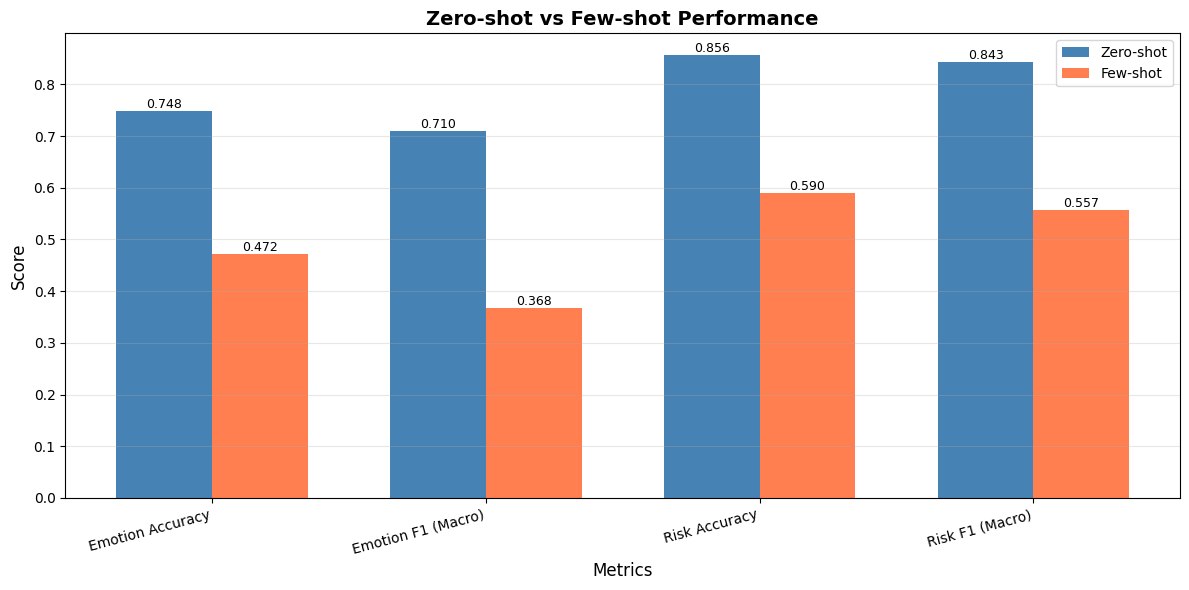


✅ 比較圖表已生成


In [ ]:
# 8. 與 Zero-shot 比較
try:
    zero_shot_metrics = pd.read_csv('zero_shot_metrics.csv')

    print("\n" + "="*80)
    print("📊 Zero-shot vs Few-shot 比較")
    print("="*80)

    comparison_data = {
        'Metric': ['Emotion Accuracy', 'Emotion F1 (Macro)', 'Risk Accuracy', 'Risk F1 (Macro)'],
        'Zero-shot': [
            zero_shot_metrics['Emotion_Accuracy'].values[0],
            zero_shot_metrics['Emotion_F1_Macro'].values[0],
            zero_shot_metrics['Risk_Accuracy'].values[0],
            zero_shot_metrics['Risk_F1_Macro'].values[0]
        ],
        'Few-shot': [
            emotion_accuracy,
            emotion_f1_macro,
            risk_accuracy,
            risk_f1_macro
        ]
    }

    comparison_df = pd.DataFrame(comparison_data)
    comparison_df['Improvement'] = comparison_df['Few-shot'] - comparison_df['Zero-shot']
    comparison_df['Improvement (%)'] = (comparison_df['Improvement'] / comparison_df['Zero-shot']) * 100

    print("\n" + comparison_df.to_string(index=False))

    # 視覺化比較
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(comparison_df['Metric']))
    width = 0.35

    bars1 = ax.bar(x - width/2, comparison_df['Zero-shot'], width,
                   label='Zero-shot', color='steelblue')
    bars2 = ax.bar(x + width/2, comparison_df['Few-shot'], width,
                   label='Few-shot', color='coral')

    ax.set_xlabel('Metrics', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Zero-shot vs Few-shot Performance', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['Metric'], rotation=15, ha='right')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # 在柱子上顯示數值
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    print("\n✅ 比較圖表已生成")

except FileNotFoundError:
    print("⚠️ 找不到 Zero-shot 結果,無法進行比較")

In [ ]:
# 9. 儲存 Few-shot 結果
test_sample.to_csv('few_shot_predictions.csv', index=False)

metrics_dict = {
    'Method': 'Few-shot',
    'Model': model_name,
    'N_Examples': len(few_shot_examples),
    'Sample_Size': len(test_sample),
    'Emotion_Accuracy': emotion_accuracy,
    'Emotion_F1_Macro': emotion_f1_macro,
    'Emotion_F1_Weighted': emotion_f1_weighted,
    'Risk_Accuracy': risk_accuracy,
    'Risk_F1_Macro': risk_f1_macro,
    'Risk_F1_Weighted': risk_f1_weighted
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df.to_csv('few_shot_metrics.csv', index=False)

print("✅ 結果已儲存:")
print("  - few_shot_predictions.csv")
print("  - few_shot_metrics.csv")

✅ 結果已儲存:
  - few_shot_predictions.csv
  - few_shot_metrics.csv


# LoRA 微調

In [ ]:
# 1. 安裝與匯入套件
print("📦 確保套件是最新版本...")
!pip install -q -U transformers accelerate peft bitsandbytes trl

import os
import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel
from trl import SFTTrainer
import warnings
warnings.filterwarnings('ignore')

print("✅ 套件匯入完成")
print(f"🎮 CUDA 可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU 記憶體: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

📦 確保套件是最新版本...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 kB 18.7 MB/s eta 0:00:00
✅ 套件匯入完成
🎮 CUDA 可用: True
🎮 GPU: Tesla T4
💾 GPU 記憶體: 15.83 GB


In [ ]:
# 2. 載入資料
print("📥 載入資料...")
train_df = pd.read_csv('train_with_risk.csv')
val_df = pd.read_csv('val_with_risk.csv')
test_df = pd.read_csv('test_with_risk.csv')

emotion_labels = {
    0: 'sadness', 1: 'joy', 2: 'love',
    3: 'anger', 4: 'fear', 5: 'surprise'
}

risk_labels = {
    0: 'low_risk', 1: 'mid_risk', 2: 'high_risk'
}

emotion_to_risk = {
    'sadness': 2, 'joy': 0, 'love': 0,
    'anger': 1, 'fear': 1, 'surprise': 0
}

# ✅ 使用子集
train_df = train_df.sample(n=3000, random_state=42)  # 👈 3000 筆就夠了
print(f"\n📊 資料統計:")
print(f"  訓練集: {len(train_df):,} 筆")
print(f"  驗證集: {len(val_df):,} 筆")
print(f"  測試集: {len(test_df):,} 筆")

📥 載入資料...

📊 資料統計:
  訓練集: 3,000 筆
  驗證集: 2,000 筆
  測試集: 2,000 筆


In [ ]:
# 3. 建立訓練用 Prompt
def create_training_prompt(text, emotion):
    """建立用於微調的 prompt"""
    prompt = f"""<|system|>
You are an emotion classification expert. Classify the emotion in the text.
Choose from: sadness, joy, love, anger, fear, surprise
</|system|>
<|user|>
Text: "{text}"

Emotion:</|user|>
<|assistant|>
{emotion}</|assistant|>"""
    return prompt

print("🔄 建立訓練 prompts...")

train_df['prompt'] = train_df.apply(
    lambda row: create_training_prompt(row['text'], row['emotion_name']),
    axis=1
)

val_df['prompt'] = val_df.apply(
    lambda row: create_training_prompt(row['text'], row['emotion_name']),
    axis=1
)

print("\n📝 訓練 Prompt 範例:")
print("="*80)
print(train_df.iloc[0]['prompt'])
print("="*80)

print("\n✅ Prompts 建立完成")

🔄 建立訓練 prompts...

📝 訓練 Prompt 範例:
<|system|>
You are an emotion classification expert. Classify the emotion in the text.
Choose from: sadness, joy, love, anger, fear, surprise
</|system|>
<|user|>
Text: "ive made it through a week i just feel beaten down"

Emotion:</|user|>
<|assistant|>
sadness</|assistant|>

✅ Prompts 建立完成


In [ ]:
# 4. 轉換為 HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df[['prompt']])
val_dataset = Dataset.from_pandas(val_df[['prompt']])

print("✅ Dataset 轉換完成")
print(f"  訓練: {len(train_dataset)} 筆")
print(f"  驗證: {len(val_dataset)} 筆")

✅ Dataset 轉換完成
  訓練: 3000 筆
  驗證: 2000 筆


In [ ]:
# 5. 載入基礎模型
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

print(f"📦 載入模型: {model_name}")
print("⏳ 請稍候...")

# 4-bit 量化配置 (QLoRA)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# 載入 tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# 載入模型
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# 準備模型進行 k-bit 訓練
model = prepare_model_for_kbit_training(model)

print("\n✅ 模型載入完成")
print(f"📊 參數量: {model.num_parameters() / 1e9:.2f}B")
print(f"💾 記憶體: {model.get_memory_footprint() / 1e9:.2f} GB")

📦 載入模型: TinyLlama/TinyLlama-1.1B-Chat-v1.0
⏳ 請稍候...

✅ 模型載入完成
📊 參數量: 1.10B
💾 記憶體: 1.01 GB


In [ ]:
# 6. 配置 LoRA
lora_config = LoraConfig(
    r=16,                          # LoRA 秩
    lora_alpha=32,                 # 縮放係數
    target_modules=[               # 要訓練的模組
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj"
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# 應用 LoRA
model = get_peft_model(model, lora_config)

# 顯示可訓練參數
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print("\n✅ LoRA 配置完成")
print(f"\n📊 參數統計:")
print(f"  可訓練參數: {trainable_params:,} ({trainable_params/total_params*100:.2f}%)")
print(f"  總參數量:   {total_params:,}")
print(f"  參數減少:   {100 - trainable_params/total_params*100:.2f}%")


✅ LoRA 配置完成

📊 參數統計:
  可訓練參數: 12,615,680 (2.01%)
  總參數量:   628,221,952
  參數減少:   97.99%


In [ ]:
# 7.5 優化的資料處理 (修正版)
from transformers import DataCollatorForLanguageModeling

print("🔄 預先 tokenizing 資料集...")

def tokenize_function(examples):
    """修正後的 tokenization - 確保長度一致"""
    # Tokenize 並直接 padding
    result = tokenizer(
        examples["prompt"],
        truncation=True,
        max_length=512,
        padding="max_length",  # 👈 改為 max_length padding
        return_tensors=None,   # 👈 先不轉換為 tensor
    )
    # 設定 labels (複製 input_ids)
    result["labels"] = result["input_ids"].copy()
    return result

# 預先處理資料集
tokenized_train = train_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=100,
    remove_columns=train_dataset.column_names,
    desc="Tokenizing train"
)

tokenized_val = val_dataset.map(
    tokenize_function,
    batched=True,
    batch_size=100,
    remove_columns=val_dataset.column_names,
    desc="Tokenizing validation"
)

print(f"✅ Tokenization 完成!")
print(f"   訓練集: {len(tokenized_train)} 筆")
print(f"   驗證集: {len(tokenized_val)} 筆")

# 檢查資料格式
print(f"\n🔍 檢查資料格式:")
sample = tokenized_train[0]
print(f"   input_ids 長度: {len(sample['input_ids'])}")
print(f"   labels 長度: {len(sample['labels'])}")
print(f"   類型: {type(sample['input_ids'])}")

# 簡單的 data collator (不需要額外 padding)
from transformers import default_data_collator
data_collator = default_data_collator

🔄 預先 tokenizing 資料集...


Tokenizing train:   0%|          | 0/3000 [00:00<?, ? examples/s]

Tokenizing validation:   0%|          | 0/2000 [00:00<?, ? examples/s]

✅ Tokenization 完成!
   訓練集: 3000 筆
   驗證集: 2000 筆

🔍 檢查資料格式:
   input_ids 長度: 512
   labels 長度: 512
   類型: <class 'list'>


In [ ]:
# 7. 優化的訓練配置
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=2,                    # 2 epochs 就夠了
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,         # 有效 batch size = 8
    learning_rate=2e-4,
    warmup_steps=50,
    logging_steps=20,                      # 👈 更頻繁的日誌
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=200,
    save_total_limit=1,
    load_best_model_at_end=True,
    fp16=True,
    optim="paged_adamw_8bit",
    lr_scheduler_type="cosine",
    max_grad_norm=0.3,
    report_to="none",
    dataloader_num_workers=0,              # 👈 重要!
    remove_unused_columns=False,           # 👈 加上這個
    gradient_checkpointing=False,          # 👈 關閉以加速
)

print("✅ 訓練配置完成")
total_steps = len(tokenized_train) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps) * training_args.num_train_epochs
print(f"\n📊 訓練統計:")
print(f"  總訓練步數: {total_steps}")
print(f"  預計時間: ~{total_steps * 0.5 / 60:.1f} 分鐘 (假設 2 it/s)")

✅ 訓練配置完成

📊 訓練統計:
  總訓練步數: 750
  預計時間: ~6.2 分鐘 (假設 2 it/s)


In [ ]:
# 8. 建立 Trainer (使用修正後的資料)
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,  # 👈 使用 default_data_collator
)

print("✅ Trainer 建立完成")
print("\n🚀 準備開始訓練...")

✅ Trainer 建立完成

🚀 準備開始訓練...


In [ ]:
# 9. 開始訓練
print("="*80)
print("🚀 開始 LoRA 微調訓練")
print("="*80)
print("\n⏳ 預計需要 6-12 分鐘...")
print("💡 監控下方的訓練速度 (it/s)\n")

# 開始訓練
trainer.train()

print("\n" + "="*80)
print("✅ 訓練完成!")
print("="*80)

🚀 開始 LoRA 微調訓練

⏳ 預計需要 6-12 分鐘...
💡 監控下方的訓練速度 (it/s)



`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
100,0.148100,0.141858
200,0.136800,0.139676
300,0.147000,0.138405
400,0.124100,0.138358
500,0.132600,0.138250
600,0.114100,0.138279
700,0.123500,0.138115



✅ 訓練完成!


In [ ]:
# 10. 儲存微調後的模型
output_dir = "./emotion_lora_model"

print(f"💾 儲存模型至: {output_dir}")
trainer.model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print("\n✅ 模型儲存完成!")
print(f"\n📁 儲存的檔案:")
!ls -lh {output_dir}

# 計算模型大小
import os
total_size = sum(
    os.path.getsize(os.path.join(output_dir, f))
    for f in os.listdir(output_dir)
    if os.path.isfile(os.path.join(output_dir, f))
)

print(f"\n📊 LoRA adapter 大小: {total_size / 1e6:.2f} MB")
print("   (相比完整模型 ~1.1GB 非常輕量!)")

💾 儲存模型至: ./emotion_lora_model

✅ 模型儲存完成!

📁 儲存的檔案:
total 53M
-rw-r--r-- 1 root root  946 Nov 12 14:44 adapter_config.json
-rw-r--r-- 1 root root  49M Nov 12 14:44 adapter_model.safetensors
-rw-r--r-- 1 root root  410 Nov 12 14:44 chat_template.jinja
-rw-r--r-- 1 root root 5.1K Nov 12 14:44 README.md
-rw-r--r-- 1 root root  437 Nov 12 14:44 special_tokens_map.json
-rw-r--r-- 1 root root  951 Nov 12 14:44 tokenizer_config.json
-rw-r--r-- 1 root root 3.5M Nov 12 14:44 tokenizer.json
-rw-r--r-- 1 root root 489K Nov 12 14:44 tokenizer.model

📊 LoRA adapter 大小: 54.63 MB
   (相比完整模型 ~1.1GB 非常輕量!)


In [ ]:
# 11. 載入微調後的模型進行推論
print("📦 載入微調後的模型...")

# 載入基礎模型
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# 載入 LoRA adapter
finetuned_model = PeftModel.from_pretrained(base_model, output_dir)
finetuned_model.eval()

print("✅ 微調模型載入完成!")

📦 載入微調後的模型...
✅ 微調模型載入完成!


In [ ]:
# 12. 定義推論函數
def predict_emotion_lora(text, model, tokenizer, max_new_tokens=10):
    """使用微調後的模型預測情緒"""

    prompt = f"""<|system|>
You are an emotion classification expert. Classify the emotion in the text.
Choose from: sadness, joy, love, anger, fear, surprise
</|system|>
<|user|>
Text: "{text}"

Emotion:</|user|>
<|assistant|>
"""

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.1,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    try:
        response = generated_text.split("<|assistant|>")[-1].strip().lower()
        response = response.replace('.', '').replace(',', '').replace('!', '').strip()

        valid_emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

        for emotion in valid_emotions:
            if emotion in response:
                return emotion

        return 'joy'
    except:
        return 'joy'

# 測試微調後的模型
print("🧪 測試微調後的模型...")
print("="*80)

for i in range(5):
    text = test_df.iloc[i]['text']
    true_emotion = emotion_labels[test_df.iloc[i]['label']]
    pred_emotion = predict_emotion_lora(text, finetuned_model, tokenizer)

    print(f"\n範例 {i+1}:")
    print(f"  文本: {text}")
    print(f"  真實: {true_emotion}")
    print(f"  預測: {pred_emotion}")
    print(f"  {'✅ 正確' if pred_emotion == true_emotion else '❌ 錯誤'}")

print("\n" + "="*80)

🧪 測試微調後的模型...

範例 1:
  文本: im feeling rather rotten so im not very ambitious right now
  真實: sadness
  預測: sadness
  ✅ 正確

範例 2:
  文本: im updating my blog because i feel shitty
  真實: sadness
  預測: sadness
  ✅ 正確

範例 3:
  文本: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
  真實: sadness
  預測: sadness
  ✅ 正確

範例 4:
  文本: i left with my bouquet of red and yellow tulips under my arm feeling slightly more optimistic than when i arrived
  真實: joy
  預測: joy
  ✅ 正確

範例 5:
  文本: i was feeling a little vain when i did this one
  真實: sadness
  預測: love
  ❌ 錯誤



In [ ]:
# 13. 對測試集進行完整評估
from tqdm import tqdm

sample_size = 500
test_sample = test_df.sample(n=min(sample_size, len(test_df)), random_state=42)

print(f"🚀 開始評估微調模型 ({len(test_sample)} 筆)...")
print("⏳ 請稍候...\n")

predictions = []
true_labels = []

for idx, row in tqdm(test_sample.iterrows(), total=len(test_sample), desc="LoRA Inference"):
    text = row['text']
    true_emotion_id = row['label']

    pred_emotion = predict_emotion_lora(text, finetuned_model, tokenizer)

    emotion_to_id = {v: k for k, v in emotion_labels.items()}
    pred_emotion_id = emotion_to_id.get(pred_emotion, 1)

    predictions.append(pred_emotion_id)
    true_labels.append(true_emotion_id)

test_sample = test_sample.copy()
test_sample['pred_emotion_id'] = predictions
test_sample['pred_emotion'] = test_sample['pred_emotion_id'].map(emotion_labels)
test_sample['pred_risk_id'] = test_sample['pred_emotion'].map(emotion_to_risk)
test_sample['pred_risk'] = test_sample['pred_risk_id'].map(risk_labels)

print("\n✅ 評估完成!")

🚀 開始評估微調模型 (500 筆)...
⏳ 請稍候...



LoRA Inference: 100%|██████████| 500/500 [09:37<00:00,  1.15s/it]


✅ 評估完成!


In [ ]:
# 14. 計算評估指標
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, accuracy_score
)

# 情緒分類評估
print("\n" + "="*80)
print("📊 情緒分類評估結果 (LoRA Fine-tuned)")
print("="*80)

y_true_emotion = test_sample['label'].values
y_pred_emotion = test_sample['pred_emotion_id'].values

emotion_accuracy = accuracy_score(y_true_emotion, y_pred_emotion)
emotion_f1_macro = f1_score(y_true_emotion, y_pred_emotion, average='macro')
emotion_f1_weighted = f1_score(y_true_emotion, y_pred_emotion, average='weighted')

print(f"\n✨ 準確率: {emotion_accuracy:.4f} ({emotion_accuracy*100:.2f}%)")
print(f"\n📈 F1 分數:")
print(f"  Macro:    {emotion_f1_macro:.4f}")
print(f"  Weighted: {emotion_f1_weighted:.4f}")

print(f"\n📋 詳細分類報告:")
print(classification_report(
    y_true_emotion, y_pred_emotion,
    target_names=list(emotion_labels.values()),
    digits=4
))

# 風險等級評估
print("\n" + "="*80)
print("⚠️ 風險等級評估結果 (LoRA Fine-tuned)")
print("="*80)

y_true_risk = test_sample['risk_id'].values
y_pred_risk = test_sample['pred_risk_id'].values

risk_accuracy = accuracy_score(y_true_risk, y_pred_risk)
risk_f1_macro = f1_score(y_true_risk, y_pred_risk, average='macro')
risk_f1_weighted = f1_score(y_true_risk, y_pred_risk, average='weighted')

print(f"\n✨ 準確率: {risk_accuracy:.4f} ({risk_accuracy*100:.2f}%)")
print(f"\n📈 F1 分數:")
print(f"  Macro:    {risk_f1_macro:.4f}")
print(f"  Weighted: {risk_f1_weighted:.4f}")

print(f"\n📋 詳細分類報告:")
print(classification_report(
    y_true_risk, y_pred_risk,
    target_names=list(risk_labels.values()),
    digits=4
))


📊 情緒分類評估結果 (LoRA Fine-tuned)

✨ 準確率: 0.7480 (74.80%)

📈 F1 分數:
  Macro:    0.7103
  Weighted: 0.7604

📋 詳細分類報告:
              precision    recall  f1-score   support

     sadness     0.8540    0.7905    0.8211       148
         joy     0.9435    0.6686    0.7826       175
        love     0.4118    0.7778    0.5385        45
       anger     0.7797    0.7931    0.7863        58
        fear     0.6716    0.8182    0.7377        55
    surprise     0.5000    0.7368    0.5957        19

    accuracy                         0.7480       500
   macro avg     0.6934    0.7642    0.7103       500
weighted avg     0.8034    0.7480    0.7604       500


⚠️ 風險等級評估結果 (LoRA Fine-tuned)

✨ 準確率: 0.8560 (85.60%)

📈 F1 分數:
  Macro:    0.8426
  Weighted: 0.8564

📋 詳細分類報告:
              precision    recall  f1-score   support

    low_risk     0.9072    0.8996    0.9034       239
    mid_risk     0.7619    0.8496    0.8033       113
   high_risk     0.8540    0.7905    0.8211       148

    accuracy

In [ ]:
# 15. 儲存結果
test_sample.to_csv('lora_predictions.csv', index=False)

metrics_dict = {
    'Method': 'LoRA Fine-tuned',
    'Model': model_name,
    'LoRA_Rank': lora_config.r,
    'Training_Epochs': training_args.num_train_epochs,
    'Sample_Size': len(test_sample),
    'Emotion_Accuracy': emotion_accuracy,
    'Emotion_F1_Macro': emotion_f1_macro,
    'Emotion_F1_Weighted': emotion_f1_weighted,
    'Risk_Accuracy': risk_accuracy,
    'Risk_F1_Macro': risk_f1_macro,
    'Risk_F1_Weighted': risk_f1_weighted
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df.to_csv('lora_metrics.csv', index=False)

print("✅ 結果已儲存:")
print("  - lora_predictions.csv")
print("  - lora_metrics.csv")

✅ 結果已儲存:
  - lora_predictions.csv
  - lora_metrics.csv


# 完整比較

In [ ]:
# 1. 匯入套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, accuracy_score,
    roc_auc_score, average_precision_score
)
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

# 設定繪圖風格
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ 套件匯入完成")

✅ 套件匯入完成


In [ ]:
# 2. 載入三種方法的結果
print("📥 載入預測結果...")

try:
    zero_shot_df = pd.read_csv('zero_shot_predictions.csv')
    print(f"  ✓ Zero-shot: {len(zero_shot_df)} 筆")
except:
    print("  ✗ Zero-shot 結果未找到")
    zero_shot_df = None

try:
    few_shot_df = pd.read_csv('few_shot_predictions.csv')
    print(f"  ✓ Few-shot: {len(few_shot_df)} 筆")
except:
    print("  ✗ Few-shot 結果未找到")
    few_shot_df = None

try:
    lora_df = pd.read_csv('lora_predictions.csv')
    print(f"  ✓ LoRA: {len(lora_df)} 筆")
except:
    print("  ✗ LoRA 結果未找到")
    lora_df = None

# 載入評估指標
print("\n📊 載入評估指標...")
metrics_list = []

try:
    zero_shot_metrics = pd.read_csv('zero_shot_metrics.csv')
    metrics_list.append(zero_shot_metrics)
    print("  ✓ Zero-shot metrics")
except:
    print("  ✗ Zero-shot metrics 未找到")

try:
    few_shot_metrics = pd.read_csv('few_shot_metrics.csv')
    metrics_list.append(few_shot_metrics)
    print("  ✓ Few-shot metrics")
except:
    print("  ✗ Few-shot metrics 未找到")

try:
    lora_metrics = pd.read_csv('lora_metrics.csv')
    metrics_list.append(lora_metrics)
    print("  ✓ LoRA metrics")
except:
    print("  ✗ LoRA metrics 未找到")

print("\n✅ 資料載入完成")

📥 載入預測結果...
  ✓ Zero-shot: 500 筆
  ✓ Few-shot: 500 筆
  ✓ LoRA: 500 筆

📊 載入評估指標...
  ✓ Zero-shot metrics
  ✓ Few-shot metrics
  ✓ LoRA metrics

✅ 資料載入完成


In [ ]:
# 3. 三種方法的效能比較
if metrics_list:
    all_metrics = pd.concat(metrics_list, ignore_index=True)

    print("\n" + "="*100)
    print("📊 三種方法效能比較表")
    print("="*100)

    # 選擇要顯示的欄位
    display_cols = ['Method', 'Emotion_Accuracy', 'Emotion_F1_Macro',
                    'Risk_Accuracy', 'Risk_F1_Macro']

    comparison_table = all_metrics[display_cols].copy()

    # 格式化為百分比
    for col in display_cols[1:]:
        comparison_table[col + '_pct'] = (comparison_table[col] * 100).round(2)

    print("\n" + comparison_table.to_string(index=False))
    print("\n" + "="*100)

    # 儲存比較表
    comparison_table.to_csv('method_comparison.csv', index=False)
    print("\n✅ 比較表已儲存至: method_comparison.csv")
else:
    print("\n⚠️ 沒有足夠的指標資料進行比較")


📊 三種方法效能比較表

         Method  Emotion_Accuracy  Emotion_F1_Macro  Risk_Accuracy  Risk_F1_Macro  Emotion_Accuracy_pct  Emotion_F1_Macro_pct  Risk_Accuracy_pct  Risk_F1_Macro_pct
      Zero-shot             0.454          0.309434          0.558       0.467493                  45.4                 30.94               55.8              46.75
       Few-shot             0.472          0.367782          0.590       0.556715                  47.2                 36.78               59.0              55.67
LoRA Fine-tuned             0.748          0.710316          0.856       0.842587                  74.8                 71.03               85.6              84.26


✅ 比較表已儲存至: method_comparison.csv


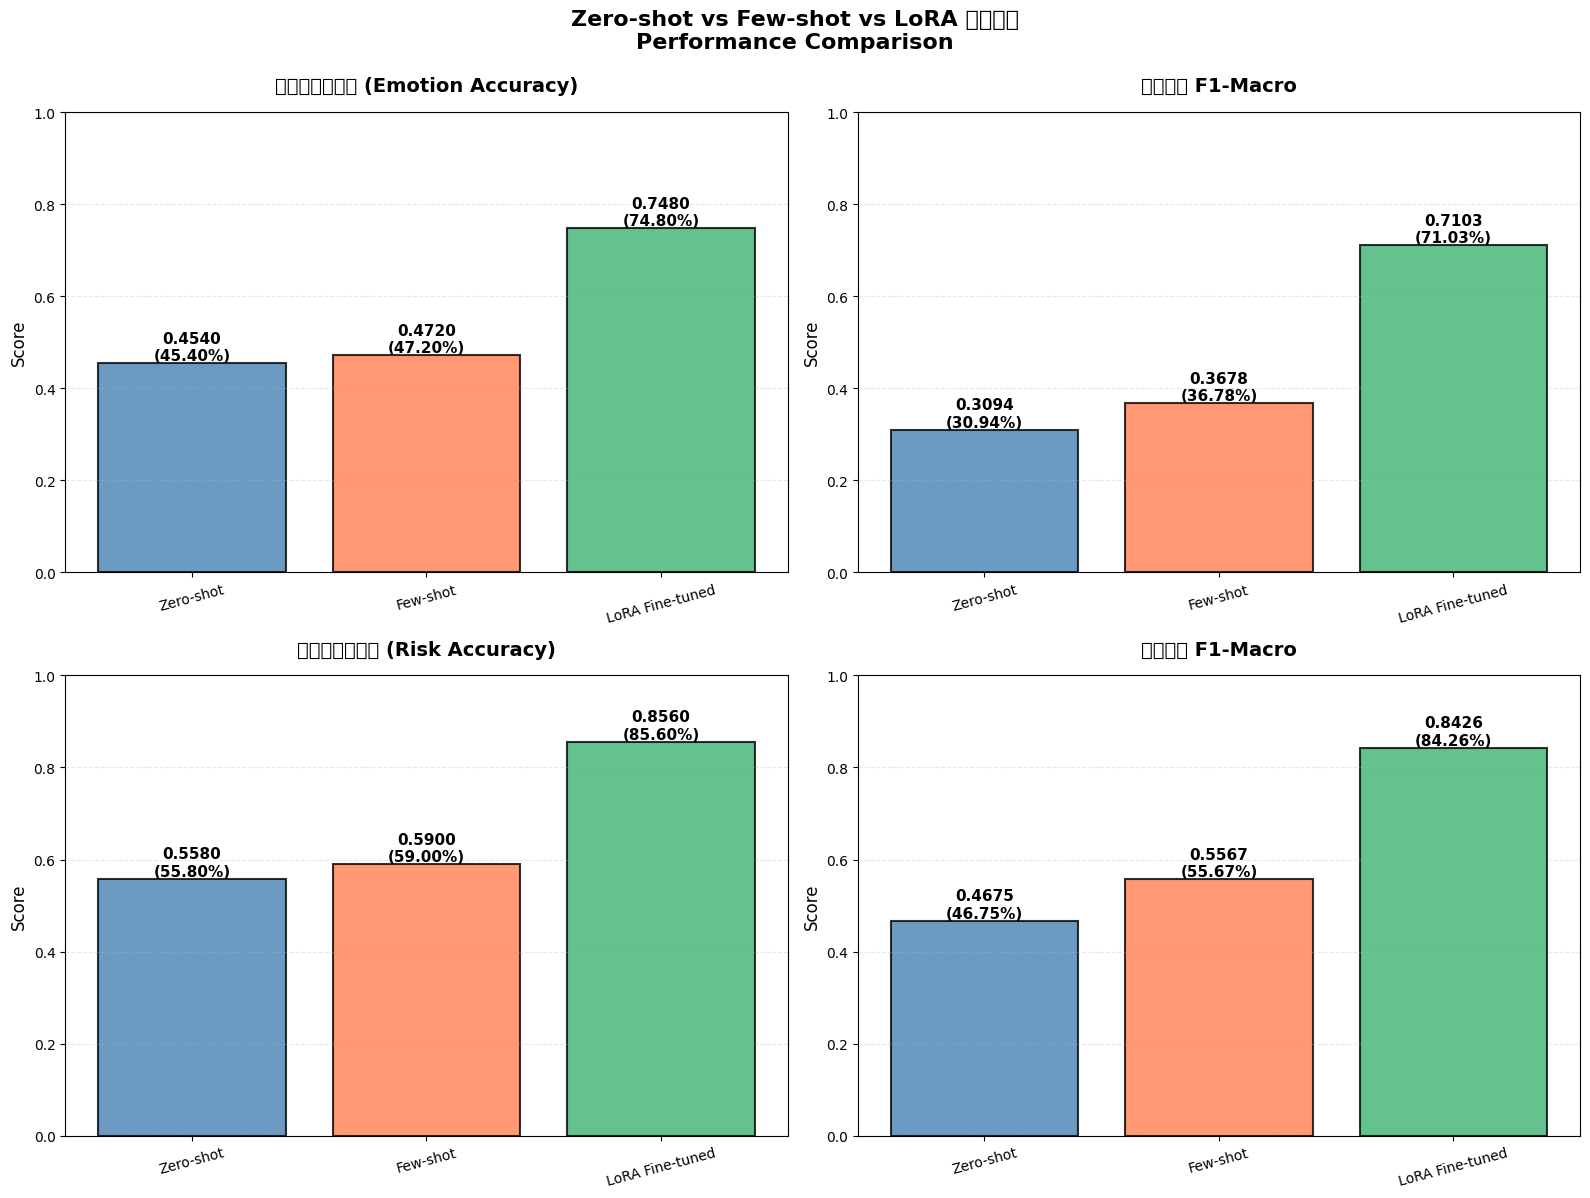

✅ 比較圖表已儲存: methods_comparison_bars.png


In [ ]:
# 4. 視覺化比較 - 長條圖
if metrics_list:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    metrics_to_plot = [
        ('Emotion_Accuracy', '情緒分類準確率 (Emotion Accuracy)', axes[0, 0]),
        ('Emotion_F1_Macro', '情緒分類 F1-Macro', axes[0, 1]),
        ('Risk_Accuracy', '風險等級準確率 (Risk Accuracy)', axes[1, 0]),
        ('Risk_F1_Macro', '風險等級 F1-Macro', axes[1, 1])
    ]

    colors = ['steelblue', 'coral', 'mediumseagreen']

    for metric_col, title, ax in metrics_to_plot:
        methods = all_metrics['Method'].values
        values = all_metrics[metric_col].values

        bars = ax.bar(methods, values, color=colors[:len(methods)],
                     edgecolor='black', linewidth=1.5, alpha=0.8)

        # 添加數值標籤
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}\n({height*100:.2f}%)',
                   ha='center', va='bottom', fontsize=11, fontweight='bold')

        ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
        ax.set_ylabel('Score', fontsize=12)
        ax.set_ylim([0, 1.0])
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.tick_params(axis='x', rotation=15)

    plt.suptitle('Zero-shot vs Few-shot vs LoRA 效能比較\nPerformance Comparison',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('methods_comparison_bars.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ 比較圖表已儲存: methods_comparison_bars.png")

In [ ]:
# 5. 計算 AUROC 和 PR-AUC
emotion_labels = {
    0: 'sadness', 1: 'joy', 2: 'love',
    3: 'anger', 4: 'fear', 5: 'surprise'
}

risk_labels = {
    0: 'low_risk', 1: 'mid_risk', 2: 'high_risk'
}

def calculate_auroc_prauc(y_true, y_pred, n_classes, task_name):
    """計算多分類的 AUROC 和 PR-AUC"""
    try:
        # 二值化標籤
        y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))
        y_pred_bin = label_binarize(y_pred, classes=list(range(n_classes)))

        # 計算 AUROC
        auroc_macro = roc_auc_score(y_true_bin, y_pred_bin, average='macro')
        # 計算 PR-AUC
        prauc_macro = average_precision_score(y_true_bin, y_pred_bin, average='macro')

        print(f"  {task_name}:")
        print(f"    AUROC: {auroc_macro:.4f}")
        print(f"    PR-AUC: {prauc_macro:.4f}")

        return auroc_macro, prauc_macro
    except Exception as e:
        print(f"  {task_name}: 計算失敗 ({e})")
        return 0.0, 0.0

print("\n" + "="*80)
print("📊 AUROC & PR-AUC 計算")
print("="*80)

auroc_prauc_results = []

for method_name, df in [("Zero-shot", zero_shot_df),
                        ("Few-shot", few_shot_df),
                        ("LoRA", lora_df)]:
    if df is not None:
        print(f"\n{'='*40}")
        print(f"{method_name} 方法")
        print(f"{'='*40}")

        # 情緒分類
        emotion_auroc, emotion_prauc = calculate_auroc_prauc(
            df['label'].values,
            df['pred_emotion_id'].values,
            n_classes=6,
            task_name="情緒分類"
        )

        # 風險等級
        risk_auroc, risk_prauc = calculate_auroc_prauc(
            df['risk_id'].values,
            df['pred_risk_id'].values,
            n_classes=3,
            task_name="風險等級"
        )

        auroc_prauc_results.append({
            'Method': method_name,
            'Emotion_AUROC': emotion_auroc,
            'Emotion_PR_AUC': emotion_prauc,
            'Risk_AUROC': risk_auroc,
            'Risk_PR_AUC': risk_prauc
        })

if auroc_prauc_results:
    auroc_prauc_df = pd.DataFrame(auroc_prauc_results)
    auroc_prauc_df.to_csv('auroc_prauc_comparison.csv', index=False)
    print("\n✅ AUROC & PR-AUC 已儲存")


📊 AUROC & PR-AUC 計算

Zero-shot 方法
  情緒分類:
    AUROC: 0.5812
    PR-AUC: 0.2302
  風險等級:
    AUROC: 0.6054
    PR-AUC: 0.4106

Few-shot 方法
  情緒分類:
    AUROC: 0.6260
    PR-AUC: 0.2517
  風險等級:
    AUROC: 0.6680
    PR-AUC: 0.4566

LoRA 方法
  情緒分類:
    AUROC: 0.8574
    PR-AUC: 0.5691
  風險等級:
    AUROC: 0.8868
    PR-AUC: 0.7608

✅ AUROC & PR-AUC 已儲存


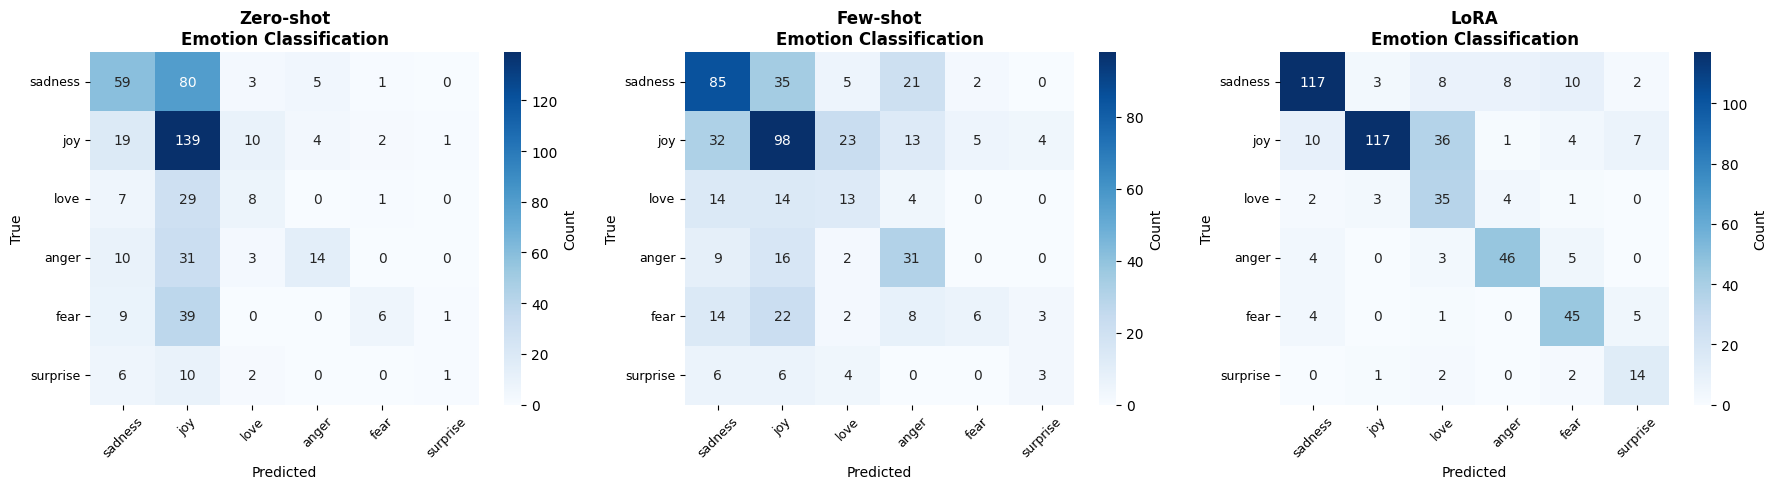

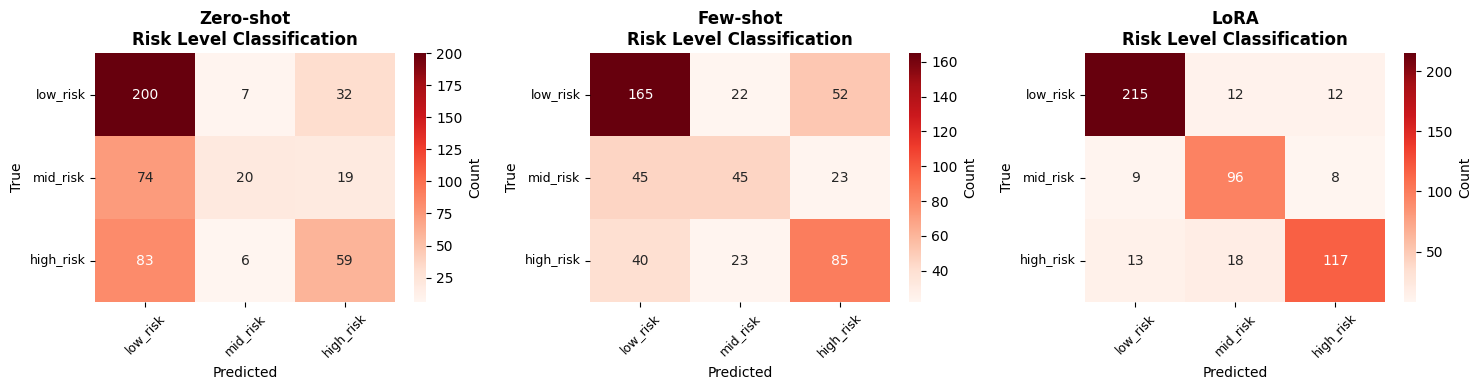

✅ 混淆矩陣比較圖已儲存


In [ ]:
# 6. 混淆矩陣比較
methods = [("Zero-shot", zero_shot_df), ("Few-shot", few_shot_df), ("LoRA", lora_df)]
available_methods = [(name, df) for name, df in methods if df is not None]

if available_methods:
    # 情緒分類混淆矩陣
    n_methods = len(available_methods)
    fig, axes = plt.subplots(1, n_methods, figsize=(6*n_methods, 5))
    if n_methods == 1:
        axes = [axes]

    for idx, (method_name, df) in enumerate(available_methods):
        cm = confusion_matrix(df['label'].values, df['pred_emotion_id'].values)

        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels.values(),
            yticklabels=emotion_labels.values(),
            ax=axes[idx], cbar_kws={'label': 'Count'}
        )
        axes[idx].set_title(f'{method_name}\nEmotion Classification',
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Predicted', fontsize=10)
        axes[idx].set_ylabel('True', fontsize=10)
        axes[idx].tick_params(axis='x', rotation=45, labelsize=9)
        axes[idx].tick_params(axis='y', rotation=0, labelsize=9)

    plt.tight_layout()
    plt.savefig('emotion_confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 風險等級混淆矩陣
    fig, axes = plt.subplots(1, n_methods, figsize=(5*n_methods, 4))
    if n_methods == 1:
        axes = [axes]

    for idx, (method_name, df) in enumerate(available_methods):
        cm = confusion_matrix(df['risk_id'].values, df['pred_risk_id'].values)

        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=risk_labels.values(),
            yticklabels=risk_labels.values(),
            ax=axes[idx], cbar_kws={'label': 'Count'}
        )
        axes[idx].set_title(f'{method_name}\nRisk Level Classification',
                           fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Predicted', fontsize=10)
        axes[idx].set_ylabel('True', fontsize=10)
        axes[idx].tick_params(axis='x', rotation=45, labelsize=9)
        axes[idx].tick_params(axis='y', rotation=0, labelsize=9)

    plt.tight_layout()
    plt.savefig('risk_confusion_matrices_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ 混淆矩陣比較圖已儲存")

📈 繪製高風險走勢圖...


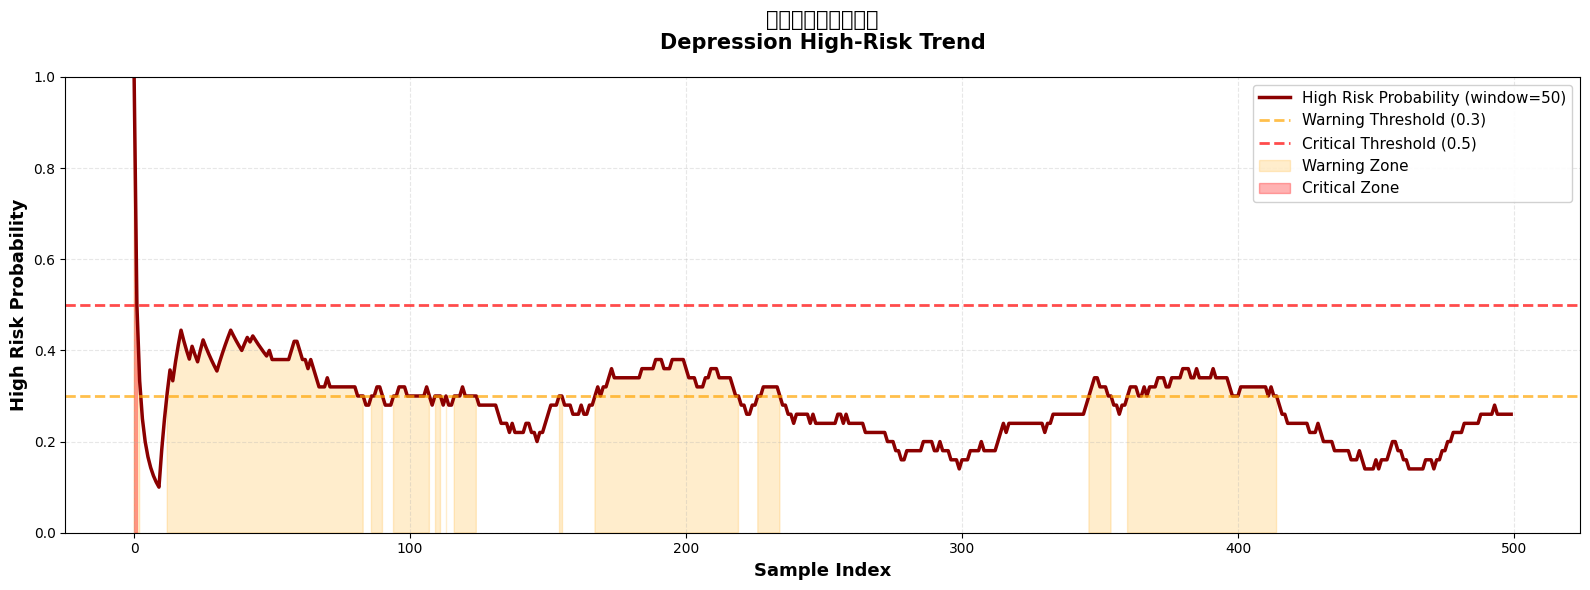

✅ 高風險走勢圖已儲存: high_risk_trend.png

📊 風險統計:
  危急風險 (≥0.5): 2 個時間點
  警告風險 (0.3-0.5): 233 個時間點
  平均風險: 0.280
  最高風險: 1.000


In [ ]:
# 7. 高風險走勢圖
# 使用最佳方法的預測結果
best_df = lora_df if lora_df is not None else (few_shot_df if few_shot_df is not None else zero_shot_df)

if best_df is not None:
    print("📈 繪製高風險走勢圖...")

    best_df = best_df.reset_index(drop=True)
    best_df['is_high_risk'] = (best_df['pred_risk_id'] == 2).astype(int)

    # 使用滾動窗口計算高風險機率
    window_size = 50
    best_df['high_risk_prob'] = best_df['is_high_risk'].rolling(
        window=window_size, min_periods=1
    ).mean()

    # 繪製走勢圖
    fig, ax = plt.subplots(figsize=(16, 6))

    # 主要走勢線
    ax.plot(best_df.index, best_df['high_risk_prob'],
           linewidth=2.5, color='darkred',
           label=f'High Risk Probability (window={window_size})')

    # 添加閾值線
    ax.axhline(y=0.3, color='orange', linestyle='--', linewidth=2,
              alpha=0.7, label='Warning Threshold (0.3)')
    ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2,
              alpha=0.7, label='Critical Threshold (0.5)')

    # 填充高風險區域
    ax.fill_between(best_df.index, 0, best_df['high_risk_prob'],
                    where=(best_df['high_risk_prob'] >= 0.3),
                    alpha=0.2, color='orange', label='Warning Zone')

    ax.fill_between(best_df.index, 0, best_df['high_risk_prob'],
                    where=(best_df['high_risk_prob'] >= 0.5),
                    alpha=0.3, color='red', label='Critical Zone')

    ax.set_xlabel('Sample Index', fontsize=13, fontweight='bold')
    ax.set_ylabel('High Risk Probability', fontsize=13, fontweight='bold')
    ax.set_title('憂鬱症高風險走勢圖\nDepression High-Risk Trend',
                fontsize=15, fontweight='bold', pad=20)
    ax.set_ylim([0, 1.0])
    ax.grid(alpha=0.3, linestyle='--')
    ax.legend(loc='upper right', fontsize=11, framealpha=0.9)

    plt.tight_layout()
    plt.savefig('high_risk_trend.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ 高風險走勢圖已儲存: high_risk_trend.png")

    # 統計資訊
    high_risk_samples = (best_df['high_risk_prob'] >= 0.5).sum()
    warning_samples = ((best_df['high_risk_prob'] >= 0.3) &
                      (best_df['high_risk_prob'] < 0.5)).sum()

    print(f"\n📊 風險統計:")
    print(f"  危急風險 (≥0.5): {high_risk_samples} 個時間點")
    print(f"  警告風險 (0.3-0.5): {warning_samples} 個時間點")
    print(f"  平均風險: {best_df['high_risk_prob'].mean():.3f}")
    print(f"  最高風險: {best_df['high_risk_prob'].max():.3f}")

🔥 繪製高風險濃度熱圖...


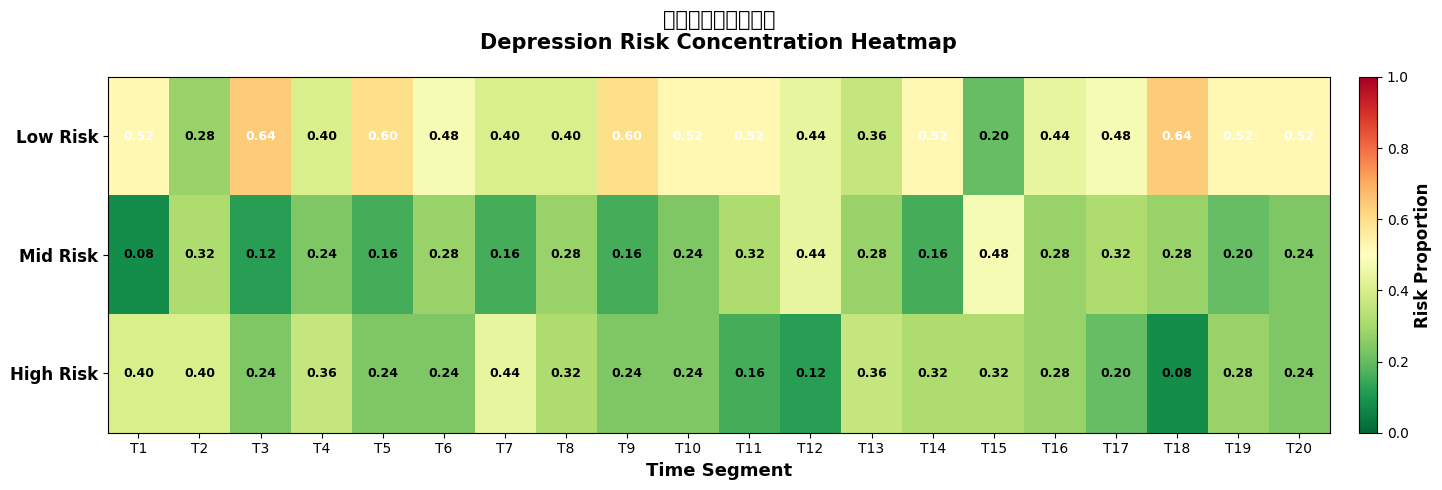

✅ 高風險濃度熱圖已儲存: high_risk_heatmap.png


In [ ]:
# 8. 高風險濃度熱圖
if best_df is not None:
    print("🔥 繪製高風險濃度熱圖...")

    # 將資料分割成時間段
    n_segments = 20
    segment_size = len(best_df) // n_segments

    heatmap_data = []
    segment_labels = []

    for i in range(n_segments):
        start_idx = i * segment_size
        end_idx = start_idx + segment_size if i < n_segments - 1 else len(best_df)

        segment = best_df.iloc[start_idx:end_idx]

        # 計算該時間段各風險等級的比例
        risk_counts = segment['pred_risk_id'].value_counts()
        total = len(segment)

        low_risk_ratio = risk_counts.get(0, 0) / total
        mid_risk_ratio = risk_counts.get(1, 0) / total
        high_risk_ratio = risk_counts.get(2, 0) / total

        heatmap_data.append([low_risk_ratio, mid_risk_ratio, high_risk_ratio])
        segment_labels.append(f"T{i+1}")

    heatmap_array = np.array(heatmap_data).T

    # 繪製熱圖
    fig, ax = plt.subplots(figsize=(16, 5))

    im = ax.imshow(heatmap_array, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=1)

    # 設定刻度
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(['Low Risk', 'Mid Risk', 'High Risk'], fontsize=12, fontweight='bold')
    ax.set_xticks(range(n_segments))
    ax.set_xticklabels(segment_labels, fontsize=10)

    # 添加數值標籤
    for i in range(3):
        for j in range(n_segments):
            value = heatmap_array[i, j]
            text_color = 'white' if value > 0.5 else 'black'
            ax.text(j, i, f'{value:.2f}',
                   ha="center", va="center", color=text_color,
                   fontsize=9, fontweight='bold')

    # 顏色條
    cbar = plt.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label('Risk Proportion', fontsize=12, fontweight='bold')

    ax.set_xlabel('Time Segment', fontsize=13, fontweight='bold')
    ax.set_title('憂鬱症風險濃度熱圖\nDepression Risk Concentration Heatmap',
                fontsize=15, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig('high_risk_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✅ 高風險濃度熱圖已儲存: high_risk_heatmap.png")